In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import Model
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn import preprocessing
from bokeh.io import output_notebook
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
from keras.layers import Dense, LSTM, Dropout, Embedding,Flatten,Bidirectional, GlobalMaxPooling1D
from keras.models import Sequential
from collections import defaultdict
from keras import regularizers
import json
output_notebook()
%matplotlib inline

Using TensorFlow backend.


Loading BokehJS ...

#### Load and prepare data

In [2]:
vocab_size= 5000
maxlen = 50
output_name_prefix = 'unrestricted'

In [3]:
def load_data(path_file, data_file, remove_no_path=False):
    frame = pd.read_csv(path_file)
    if remove_no_path:
        frame = frame[(frame.path != 'NO_PATH_A') & (frame.path != 'NO_PATH_B')]
    #frame = frame[frame.most_frequent_percentage >= 0.6]
    data_frame = pd.read_csv(data_file)
    data_frame = data_frame[data_frame.sentence.isin(frame.sentence.values.tolist())]
    output_name = '../paths-from-input-{}-empty-paths-{}.csv'.format(path_file.replace('.csv',''),(not remove_no_path))
    return frame, data_frame, output_name

#paths, data, output_name = load_data('../code/data/paths_original.csv', '../code/data/data.csv', remove_no_path=True)

In [4]:
def preprocess(path_frame):
    # transform labels into 3d tensors for lstm
    paths_list = path_frame['path'].values.tolist()
    tokenizer = Tokenizer(num_words=vocab_size,filters='', split='_')
    tokenizer.fit_on_texts(paths_list)
    input_train = tokenizer.texts_to_sequences(paths_list)
    input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
    input_train_reshaped = input_train.reshape((len(paths_list),maxlen,1))

    # create target labels, one for each path
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(paths_list)
    y_train =  to_categorical(label_encoder.transform(paths_list))
   
    print('{} paths total'.format(len(paths_list)))
    print('{} different (target) paths'.format(y_train[0].shape[0]))
    return input_train, y_train


#### Train the network

In [5]:
def plot_lines(history, first,second):
    plt.plot(history.history[first[0]],color=first[1])
    plt.plot(history.history[second[0]],linestyle='--',color=second[1])
    plt.title('{} vs {}'.format(first[0],second[0]))
    plt.xlabel('epoch')
    plt.legend([first[0],second[0]])
    plt.figure(figsize=(5,5))
    plt.show()
    

In [6]:
def train_model(layers,X,y,name='',epochs=100,batch_size=64, shuffle=True, validation_split=0.4, optimizer='adam'):
    model = Sequential(name=name)
    [model.add(layer) for layer in layers]
    model.add(Dense(y[0].shape[0],activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    print('===== {} ====='.format(name))
    model.summary()
    history = model.fit(X, y,
    epochs=epochs, batch_size=batch_size,shuffle=shuffle, validation_split=validation_split)
    return history, model
    

#### Prepare the embeddings

In [7]:
def get_embeddings(model,X):
    layer = model.layers[-2]
    #assert type(layer) == LSTM
    #assert type(model.layers[-1]) == Dense
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=layer.output)
    return intermediate_layer_model.predict(X)

### Average Embedding

In [8]:
def average_embeddings(embeddings,path_frame,data_frame):
    assert len(path_frame) == len(embeddings)

    embedding_dict = defaultdict(list)
    mean_embedding_dict = {}
    idx = 0
    for i, row in path_frame.iterrows():
        embedding_dict[row['sentence']].append(embeddings[idx])
        idx += 1

    assert len(embedding_dict)== len(data_frame)

    for k,v in embedding_dict.items():
        adder = np.zeros(v[0].shape)
        for val in v:
            adder += val
        adder /= len(v)
        mean_embedding_dict[k] = adder

    assert len(mean_embedding_dict)== len(data_frame)
    return mean_embedding_dict

In [9]:
def reformat(mean_embedding_dict,path_frame,data_frame):
    X = []
    y = []
    plot_data = []
    plot_x = []
    idx = 0
    embedding_df = pd.DataFrame(columns=['id', 'sentence', 'label', 'embedding', 'paths'])
    for k,v in mean_embedding_dict.items():
        f_slice = path_frame[path_frame.sentence == k]
        label = f_slice.most_frequent_label.values.tolist()[0]
        f_paths = f_slice.path.values.tolist()
        embedding_df.loc[idx] = [f_slice.id.values.tolist()[0], f_slice.sentence.values.tolist()[0],label,
                                 v.reshape(-1,1).squeeze().tolist(), f_paths]
        idx+=1
        # prepare results for classification
        X.append(v.reshape(-1,1).squeeze().tolist())
        y.append(label)

        # prepare results for t-sne plot
        plot_x.append(v)
        plot_data.append( (label,k,'\n'.join(f_paths)) )
    return X, y, plot_data, plot_x, embedding_df

In [10]:
def save_embedding_df(embedding_df,name):
    embedding_df.to_csv(output_name_prefix+'__'+name)

### Plot

In [11]:
def tsne_plot(plot_x, plot_data):
    X_embedded = TSNE(n_components=2,verbose=1).fit_transform(plot_x)
    plot_frame = pd.DataFrame(columns=['x','y','class','sentence', 'path'])
    for i,x in enumerate(X_embedded):
        plot_frame.loc[i] = [x[0],x[1],plot_data[i][0],plot_data[i][1],plot_data[i][2]]

    def build_source(label, df):
        df = df[df['class'] == label]
        return ColumnDataSource(data=dict(
        x=df.x.values.tolist(),
        y=df.y.values.tolist(),
        sentence=df.sentence.tolist(),
        path=df.path.tolist(),
        label=df['class'].tolist()))

    colormap = {'WORSE': 'red', 'BETTER': 'green', 'NONE': 'blue'}
    colors = [colormap[x] for x in plot_frame['class']]

    # GROUP tooltips
    hover = HoverTool(tooltips=[
        ("Sentence", "@sentence"),
        ("Path", "@path"),
        ("label", "@label"),
    ])

    p = figure(plot_width=900,  plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,previewsave")
    p.add_tools(hover)

    p.cross(x='x', y='y', source=build_source('NONE', plot_frame),size=5,color='gray')
    p.circle(x='x', y='y', source=build_source('WORSE', plot_frame) ,size=5,color='red')
    p.circle(x='x', y='y', source=build_source('BETTER', plot_frame),size=5,color='green')
    return p

### Classification Test

In [12]:
def classification_test(X,y,data_frame,with_embeddings=False):
    _X = X
    if with_embeddings:
        print("With embeddings")
        lst_lst = np.array([json.loads(l) for l in data_frame.embedding_middle_part.values.tolist()])
        paths_ = np.asarray(X)
        infersent_ = np.array(lst_lst)
        _X = np.concatenate([paths_, infersent_],axis=1)
        assert np.asarray(X).shape[0] == paths_.shape[0] == infersent_.shape[0]
        assert _X.shape[1] == paths_.shape[1] + infersent_.shape[1]
        
    else:
        print("Without embeddings")
    
    kf = StratifiedKFold(n_splits=5, random_state=42)
    
    d = defaultdict(int)

    for train_index, test_index in kf.split(_X,y):
        X_train, X_test = np.array(_X)[train_index], np.array(_X)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
     
        log = LogisticRegression()
        log.fit(X_train, y_train)
        pred = log.predict(X_test)
        print(classification_report(y_test,pred,labels=['BETTER', 'WORSE', 'NONE']))
        print('=========\n')
        print("\n\n")

In [13]:
def full_run(layers,
             name='',epochs=100,batch_size=64, shuffle=True, validation_split=0.2, optimizer='adam'):
    start = time.mktime(time.localtime())
    path_frame, data_frame, output_name = load_data('../code/data/paths_unrestricted.csv',  '../code/data/data_if.csv', remove_no_path=False)
    
    
    X, y = preprocess(path_frame)
    history, trained_model = train_model(layers,X,y, name=name,epochs=epochs,batch_size=batch_size,
                                         shuffle=shuffle, validation_split=validation_split, optimizer=optimizer)

    plot_lines(history,('acc','green'),('val_acc', 'yellowgreen'))
    plot_lines(history,('loss', 'red'), ('val_loss', 'orangered'))
    embeddings = get_embeddings(trained_model,X)
    mean_embedding_dict = average_embeddings(embeddings,path_frame,data_frame)
    _X, _y, plot_data, plot_x, embedding_df = reformat(mean_embedding_dict,path_frame,data_frame)
    
    #save_embedding_df(embedding_df,name)
    show(tsne_plot(plot_x, plot_data))
    classification_test(_X,_y,data_frame,with_embeddings=True)
    classification_test(_X,_y,data_frame)
    duration = (time.mktime(time.localtime()) - start) / 60
    print('Took {} minutes'.format(duration))

11191 paths total
9555 different (target) paths
=====  =====
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              5121024   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)

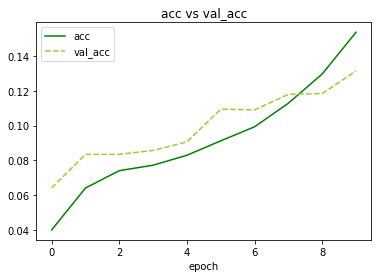

<Figure size 360x360 with 0 Axes>

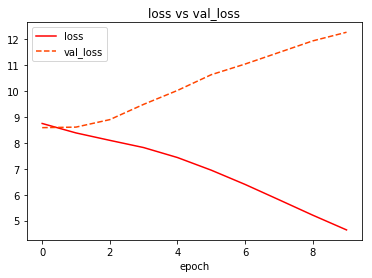

<Figure size 360x360 with 0 Axes>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5759 samples in 0.345s...
[t-SNE] Computed neighbors for 5759 samples in 55.466s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5759
[t-SNE] Computed conditional probabilities for sample 2000 / 5759
[t-SNE] Computed conditional probabilities for sample 3000 / 5759
[t-SNE] Computed conditional probabilities for sample 4000 / 5759
[t-SNE] Computed conditional probabilities for sample 5000 / 5759
[t-SNE] Computed conditional probabilities for sample 5759 / 5759
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.338745
[t-SNE] Error after 1000 iterations: 1.307703


With embeddings
             precision    recall  f1-score   support

     BETTER       0.53      0.42      0.47       219
      WORSE       0.20      0.05      0.08        95
       NONE       0.82      0.94      0.87       839

avg / total       0.72      0.76      0.73      1153





             precision    recall  f1-score   support

     BETTER       0.61      0.47      0.53       218
      WORSE       0.32      0.06      0.11        95
       NONE       0.82      0.95      0.88       839

avg / total       0.74      0.78      0.75      1152





             precision    recall  f1-score   support

     BETTER       0.62      0.53      0.57       218
      WORSE       0.33      0.06      0.11        95
       NONE       0.84      0.95      0.89       839

avg / total       0.76      0.80      0.77      1152





             precision    recall  f1-score   support

     BETTER       0.57      0.50      0.53       218
      WORSE       0.31      0.08      0.13        95
       N

In [14]:
full_run([
    Embedding(vocab_size,100,input_length=maxlen),
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2)
], epochs=10)

11191 paths total
9555 different (target) paths
=====  =====
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          93440     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 9555)              621075    
Total params: 2,247,539
Trainable params: 2,247,539
Non-trainable params: 0
_________________________________________________________________
Train on 8952 samples, validate on 2239 samples
Epoch 1/50
8952/8952 [==============================] - 22s 2ms/step - loss: 8.9316 - acc: 0.0322 - val_loss: 8.6530 - val_acc: 0.0429
Epoch 2/50
8952/8952

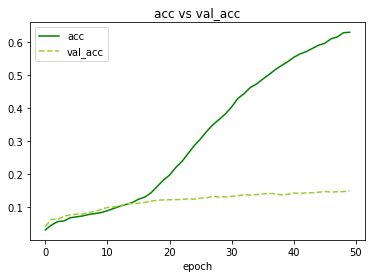

<Figure size 360x360 with 0 Axes>

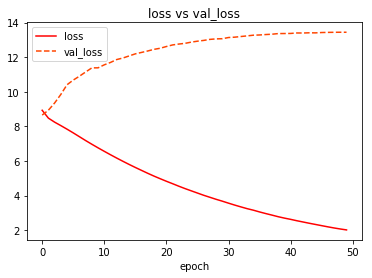

<Figure size 360x360 with 0 Axes>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5759 samples in 0.015s...
[t-SNE] Computed neighbors for 5759 samples in 2.639s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5759
[t-SNE] Computed conditional probabilities for sample 2000 / 5759
[t-SNE] Computed conditional probabilities for sample 3000 / 5759
[t-SNE] Computed conditional probabilities for sample 4000 / 5759
[t-SNE] Computed conditional probabilities for sample 5000 / 5759
[t-SNE] Computed conditional probabilities for sample 5759 / 5759
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.777367
[t-SNE] Error after 1000 iterations: 1.024286


With embeddings
             precision    recall  f1-score   support

     BETTER       0.43      0.27      0.34       219
      WORSE       0.09      0.01      0.02        95
       NONE       0.77      0.93      0.84       839

avg / total       0.65      0.73      0.68      1153







In [ ]:
full_run([
    Embedding(vocab_size,300),
    LSTM(64,return_sequences=True),
    LSTM(64,return_sequences=False)
], epochs=50)